# Objectives

Transform proper motions from one frame to another.
Compute the convex hull of a set of points.
Write an ADQL query that selects based on proper motion.

# OUTLINE

Using data from the previous episode, we will identify the values of proper motion for stars likely to be in GD-1.

Then we will compose an ADQL query that selects stars based on proper motion, so we can download only the data we need.

That will make it possible to search a bigger region of the sky in a single query.

In [1]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from gala.coordinates import GD1Koposov10, GD1, reflex_correct
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
filename = 'gd1_data.hdf'
centerline_df = pd.read_hdf(filename, 'centerline_df')
selected_df = pd.read_hdf(filename, 'selected_df')

This defines previously defined quantities:

In [4]:
def make_rectangle(x1, x2, y1, y2):
    """Return the corners of a rectangle."""
    xs = [x1, x1, x2, x2, x1]
    ys = [y1, y2, y2, y1, y1]
    return xs, ys

In [6]:
pmra_min = -6.70
pmra_max = -3
pmdec_min = -14.31
pmdec_max = -11.2

pm1_rect, pm2_rect = make_rectangle(
    pm1_min, pm1_max, pm2_min, pm2_max)
gd1_frame = GD1Koposov10()

# Selection by proper motion
Let us review how we got to this point.

1. We made an ADQL query to the Gaia server to get data for stars in the vicinity of a small part of GD-1.

2. We transformed the coordinates to the GD-1 frame (`GD1Koposov10`) so we could select stars along the centerline of GD-1.

3. We plotted the proper motion of stars along the centerline of GD-1 to identify the bounds of an anomalous overdense region associated with the proper motion of stars in GD-1.

4. We made a mask that selects stars whose proper motion is in this overdense region and which are therefore likely to be part of the GD-1 stream.

At this point we have downloaded data for a relatively large number of stars (more than 100,000) and selected a relatively small number (around 1000).

It would be more efficient to use ADQL to select only the stars we need. That would also make it possible to download data covering a larger region of the sky.

However, the selection we did was based on proper motion in the GD-1 frame. In order to do the same selection on the Gaia catalog in ADQL, we have to work with proper motions in the ICRS frame as this is the frame that the Gaia catalog uses.

First, we will verify that our proper motion selection was correct, starting with the `plot_proper_motion` function that we defined in episode 3. The following figure shows:

* Proper motion for the stars we selected along the center line of GD-1,

* The rectangle we selected, and

* The stars inside the rectangle highlighted in green.

In [7]:
def plot_proper_motion(df):
    """Plot proper motion.
    
    df: DataFrame with `pm_phi1` and `pm_phi2`
    """
    x = df['pm_phi1']
    y = df['pm_phi2']
    plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

    plt.xlabel('Proper motion phi1 (mas/yr)')
    plt.ylabel('Proper motion phi2 (mas/yr)')

    plt.xlim(-12, 8)
    plt.ylim(-10, 10)

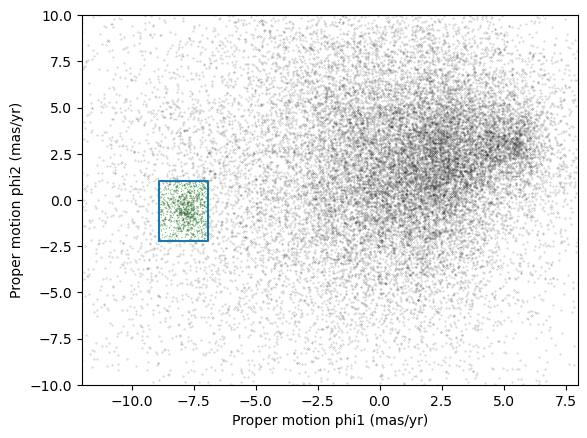

In [8]:
plot_proper_motion(centerline_df)

plt.plot(pm1_rect, pm2_rect)

x = selected_df['pm_phi1']
y = selected_df['pm_phi2']
plt.plot(x, y, 'gx', markersize=0.3, alpha=0.3);

Now we will make the same plot using proper motions in the ICRS frame, which are stored in columns named `pmra` and `pmdec`.

(-20.0, 5.0)

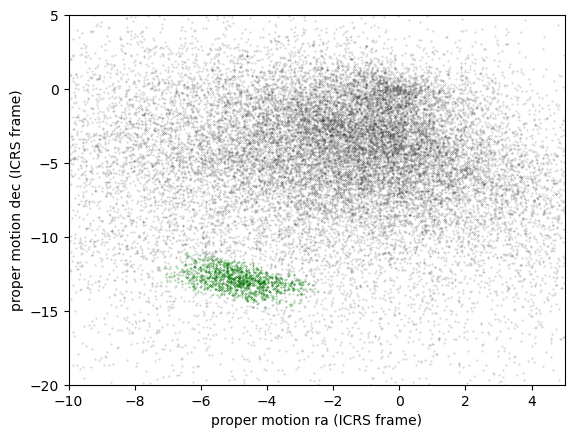

In [11]:
x=centerline_df['pmra']
y=centerline_df['pmdec']
plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

x = selected_df['pmra']
y = selected_df['pmdec']
plt.plot(x, y, 'gx', markersize=1, alpha=0.3)

plt.xlabel('proper motion ra (ICRS frame)')
plt.ylabel('proper motion dec (ICRS frame)')
plt.xlim([-10, 5])
plt.ylim([-20, 5])

# Assembling the Query

Here we will make two chnages:
1. We will select stars with coordinates in a larger region to include more of GD-1.

2. We will add another clause to select stars whose proper motion is in the range we just defined in the previous exercise.

The fact that we remove most contaminating stars with the proper motion filter is what allows us to expand our query to include most of GD-1 without returning too many results. As we did in episode 2, we will define the physical region we want to select in the GD-1 frame and transform it to the ICRS frame to query the Gaia catalog which is in the ICRS frame.

Here are tehe coordintes of the larger rectangle in the GD-1 frame

In [12]:
# The below values are choose by eye
phi1_min = -70 * u.degree
phi1_max = -20 * u.degree
phi2_min = -5 * u.degree
phi2_max = 5 * u.degree

In [13]:
phi1_rect, phi2_rect = make_rectangle(
    phi1_min, phi1_max, phi2_min, phi2_max)

In [14]:
corners=SkyCoord(phi1=phi1_rect, phi2=phi2_rect, frame=gd1_frame)
corners_icrs=corners.transform_to('icrs')

To use `corners_icrs` as part of an ADQL query, we have to convert it to a string. Fortunately, we wrote a function, `skycoord_to_string `to do this:

In [15]:
def skycoord_to_string(skycoord):
    """Convert a one-dimenstional list of SkyCoord to string for Gaia's query format."""
    corners_list_str = skycoord.to_string()
    corners_single_str = ' '.join(corners_list_str)
    return corners_single_str.replace(' ', ', ')

In [16]:
sky_point_list = skycoord_to_string(corners_icrs)
sky_point_list

'135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862'

In [17]:
# Defining the columns to select
columns = 'source_id, ra, dec, pmra, pmdec'

Now we have everything we need to assemble the query, but DO NOT try to run this query. Because it selects a larger region, there are too many stars to handle in a single query. Until we select by proper motion, that is.

In [19]:
candidate_coord_query_base = """SELECT
{columns}
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON({sky_point_list}))
"""

In [20]:
candidate_coord_query = candidate_coord_query_base.format(columns=columns, 
                            sky_point_list=sky_point_list)
print(candidate_coord_query)

SELECT
source_id, ra, dec, pmra, pmdec
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON(135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))



# Selecting proper motion

Now we are ready to add a WHERE clause to select stars whose proper motion falls range we defined in the last exercise

In [21]:
candidate_coord_pm_query_base = """SELECT 
{columns}
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON({sky_point_list}))
  AND pmra BETWEEN {pmra_min} AND  {pmra_max}
  AND pmdec BETWEEN {pmdec_min} AND {pmdec_max}
"""

In [22]:
candidate_coord_pm_query = candidate_coord_pm_query_base.format(columns=columns, 
                            sky_point_list=sky_point_list,
                            pmra_min=pmra_min,
                            pmra_max=pmra_max,
                            pmdec_min=pmdec_min,
                            pmdec_max=pmdec_max)
print(candidate_coord_pm_query)

SELECT 
source_id, ra, dec, pmra, pmdec
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON(135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))
  AND pmra BETWEEN -6.7 AND  -3
  AND pmdec BETWEEN -14.31 AND -11.2



In [23]:
candidate_coord_pm_job = Gaia.launch_job_async(candidate_coord_pm_query)
print(candidate_coord_pm_job)

INFO: Query finished. [astroquery.utils.tap.core]
<Table length=8409>
   name    dtype    unit                              description                            
--------- ------- -------- ------------------------------------------------------------------
source_id   int64          Unique source identifier (unique within a particular Data Release)
       ra float64      deg                                                    Right ascension
      dec float64      deg                                                        Declination
     pmra float64 mas / yr                         Proper motion in right ascension direction
    pmdec float64 mas / yr                             Proper motion in declination direction
Jobid: 1685952644723O
Phase: COMPLETED
Owner: None
Output file: async_20230605134044.vot
Results: None


Now get the results

In [24]:
candidate_gaia_table = candidate_coord_pm_job.get_results()
len(candidate_gaia_table)

8409

>BETWEEN VS POLYGON
>You may be wondering why we used BETWEEN for proper motion when we previously used POLYGON for coordinates. ADQL intends the POLYGON function to only be used on coordinates and not on proper motion. To enforce this, it will produce an error when a negative value is passed into the first argument.

We call the results `candidate_gaia_table` because it contains information from the Gaia table for stars that are good candidates for GD-1.

`sky_point_list`, `pmra_min`, `pmra_max`, `pmdec_min`, and `pmdec_max` are a set of selection criteria that we derived from data downloaded from the Gaia Database. To make sure we can repeat our analysis at a later date we should save this information to a file.

There are several ways we could do that, but since we are already storing data in an HDF5 file, we will do the same with these variables.

To save them to an HDF5 file we first need to put them in a Pandas object. We have seen how to create a `Series` from a column in a `DataFrame`. Now we will build a `Series` from scratch. We do not need the full DataFrame format with multiple rows and columns because we are only storing one string (`sky_point_list`). We can store each string as a row in the `Series` and save it. One aspect that is nice about `Series `is that we can label each row. To do this we need an object that can define both the name of each row and the data to go in that row. We can use a Python `Dictionary` for this, defining the row names with the dictionary keys and the row data with the dictionary values.

In [25]:
d = dict(sky_point_list=sky_point_list, pmra_min=pmra_min, pmra_max=pmra_max, pmdec_min=pmdec_min, pmdec_max=pmdec_max)
d

{'sky_point_list': '135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862',
 'pmra_min': -6.7,
 'pmra_max': -3,
 'pmdec_min': -14.31,
 'pmdec_max': -11.2}

And use this `Dictionary` to initialize a `Series`.

In [27]:
point_series = pd.Series(d)
point_series

sky_point_list    135.306, 8.39862, 126.51, 13.4449, 163.017, 54...
pmra_min                                                       -6.7
pmra_max                                                         -3
pmdec_min                                                    -14.31
pmdec_max                                                     -11.2
dtype: object

Now we can save our `Series` using `to_hdf()`.

In [28]:
filename = 'gd1_data.hdf'
point_series.to_hdf(filename, 'point_series')

/var/folders/7d/s9h888js3wg44h10jbwk1l1r0000gn/T/ipykernel_35334/1683950938.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  point_series.to_hdf(filename, 'point_series')


# Plotting one more time

Text(0, 0.5, 'dec (degree ICRS)')

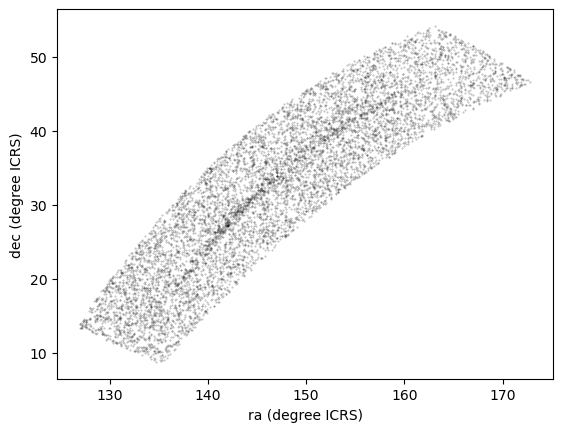

In [35]:
x=candidate_gaia_table['ra']
y=candidate_gaia_table['dec']

plt.plot(x, y, 'ko', markersize=0.4, alpha=0.3)

plt.xlabel('ra (degree ICRS)')
plt.ylabel('dec (degree ICRS)')

This plot shows why it was useful to transform these coordinates to the GD-1 frame. In ICRS, it is more difficult to identity the stars near the centerline of GD-1.

We can use our `make_dataframe` function from episode 3 to transform the results back to the GD-1 frame. In addition to doing the coordinate transformation and reflex correction for us, this function also compiles everything into a single object (a `DataFrame)` to make it easier to use. Note that because we put this code into a function, we can do all of this with a single line of code!

In [36]:
def make_dataframe(table):
    """Transform coordinates from ICRS to GD-1 frame.
    
    table: Astropy Table
    
    returns: Pandas DataFrame
    """
    #Create a SkyCoord object with the coordinates and proper motions
    # in the input table
    skycoord = SkyCoord(
               ra=table['ra'], 
               dec=table['dec'],
               pm_ra_cosdec=table['pmra'],
               pm_dec=table['pmdec'], 
               distance=8*u.kpc, 
               radial_velocity=0*u.km/u.s)

    # Define the GD-1 reference frame
    gd1_frame = GD1Koposov10()

    # Transform input coordinates to the GD-1 reference frame
    transformed = skycoord.transform_to(gd1_frame)

    # Correct GD-1 coordinates for solar system motion around galactic center
    skycoord_gd1 = reflex_correct(transformed)

    #Add GD-1 reference frame columns for coordinates and proper motions
    table['phi1'] = skycoord_gd1.phi1
    table['phi2'] = skycoord_gd1.phi2
    table['pm_phi1'] = skycoord_gd1.pm_phi1_cosphi2
    table['pm_phi2'] = skycoord_gd1.pm_phi2

    # Create DataFrame
    df = table.to_pandas()

    return df

In [37]:
candidate_gaia_df = make_dataframe(candidate_gaia_table)

In [43]:
def plot_pm_selection(df):
    """Plot in GD-1 spatial coordinates the location of the stars
    selected by proper motion
    """
    x = df['phi1']
    y = df['phi2']

    plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

    plt.xlabel('phi1 [deg]')
    plt.ylabel('phi2 [deg]')
    plt.title('Proper motion selection', fontsize='medium')

    plt.axis('equal')

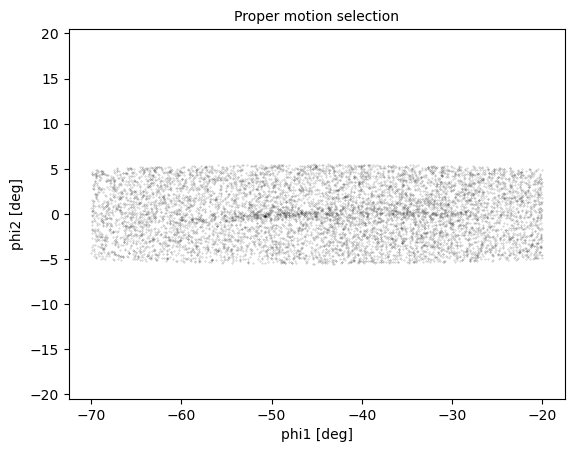

In [44]:
plot_pm_selection(candidate_gaia_df)